# Statistics for the Text-Triple Pairs Consisting of Protein-Protein-Interactions (PPIs)

This notebook filters and counts the text-triple pairs in the pre-training and fine-tuning datasets employed in STonKGs
that solely cover protein-protein interactions.

In [1]:
# Imports
import getpass
import os
import sys
import time

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib
from matplotlib.ticker import FuncFormatter
from transformers import BertTokenizer

from stonkgs.constants import (
    CELL_LINE_DIR,
    CELL_TYPE_DIR,
    CORRECT_DIR,
    DISEASE_DIR,
    LOCATION_DIR,
    MISC_DIR,
    ORGAN_DIR,
    PRETRAINING_DIR,
    RELATION_TYPE_DIR,
    SPECIES_DIR,
    VISUALIZATIONS_DIR,
)

Log when/how this notebook has been created

In [2]:
print(getpass.getuser())
print(sys.version)
print(time.asctime())

hbalabin
3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
Thu Sep  2 13:52:56 2021


## A) INDRA Pre-training
### A1) Load the Dataset

In [4]:
indra_pretraining = pd.read_csv(os.path.join(PRETRAINING_DIR, "pretraining_triples.tsv"), sep="\t", index_col=None)

In [61]:
indra_pretraining.head()

,source,relation,target,evidence,pmid,belief_score
0,a(PUBCHEM:5280427 ! 5280427),increases,a(PUBCHEM:6076 ! 6076),Prostacyclin (PGI2) increased cyclic AMP in sp...,"other:""reach:Unknown""",{1: True}
1,a(PUBCHEM:5280427 ! 5280427),increases,a(PUBCHEM:6076 ! 6076),Elevation of cyclic AMP by prostacyclin is acc...,"other:""reach:Unknown""",{1: True}
2,a(PUBCHEM:5280427 ! 5280427),increases,a(PUBCHEM:6076 ! 6076),"In addition, 0.2 microM prostacyclin, 50 micro...","other:""reach:Unknown""",{1: True}
3,a(PUBCHEM:5280427 ! 5280427),increases,a(PUBCHEM:6076 ! 6076),Prostacyclin strongly stimulates cyclic AMP sy...,"other:""reach:Unknown""",{1: True}
4,a(PUBCHEM:5280427 ! 5280427),increases,a(PUBCHEM:6076 ! 6076),This marked difference in potency was even mor...,"other:""reach:Unknown""",{1: True}


In [62]:
print(f"Number of entries in the pre-training data: {len(indra_pretraining)}")

Number of entries in the pre-training data: 13609994


### A2) Filter for PPIs
(Based on filtering for node names that start with **"p(HGNC"**.) 

In [5]:
indra_pretraining_ppi = indra_pretraining[indra_pretraining["source"].str.startswith('p(HGNC') &
                                          indra_pretraining["target"].str.startswith('p(HGNC')]

In [29]:
print(f"Number of entries in the pre-training data after filtering for PPIs: {len(indra_pretraining_ppi)}")
print(f"This makes up {len(indra_pretraining_ppi)/len(indra_pretraining)*100}% of the total pre-training triples")

Number of entries in the pre-training data after filtering for PPIs: 3069101
This makes up 22.550347928147506% of the total pre-training triples


### A3) Save the PPI pre-training dataset

In [65]:
# indra_pretraining_ppi.to_csv(os.path.join(PRETRAINING_DIR, "pretraining_triples_ppi.tsv"), sep="\t", index=None)

## B) INDRA Fine-tuning
### B1) Load the datasets 

In [16]:
directories = [
    CELL_LINE_DIR,
    CELL_TYPE_DIR,
    CORRECT_DIR,
    CORRECT_DIR,
    DISEASE_DIR,
    LOCATION_DIR,
    ORGAN_DIR,
    SPECIES_DIR,
    RELATION_TYPE_DIR,
    RELATION_TYPE_DIR,
]
file_names = [
    "cell_line_no_duplicates.tsv",
    "cell_type_no_duplicates.tsv",
    "correct_incorrect_binary_no_duplicates.tsv",
    "correct_incorrect_multiclass_no_duplicates.tsv",
    "disease_no_duplicates.tsv",
    "location_no_duplicates.tsv",
    "organ_no_duplicates.tsv",
    "species_no_duplicates.tsv",
    "relation_type_no_duplicates.tsv",
    "relation_type_no_duplicates.tsv",
]
task_names = [
    "cell_line",
    "cell_type",
    "correct_binary",
    "correct_multiclass",
    "disease",
    "location",
    "organ",
    "species",
    "interaction",
    "polarity",
]
# Specify the column names of the target variable
column_names = ["class"] * 8 + ["interaction"] + ["polarity"]

finetuning_datasets = [pd.read_csv(os.path.join(directory, file_name), sep="\t", index_col=None, 
                                  usecols =[i for i in list(pd.read_csv(os.path.join(directory, file_name), sep="\t", nrows=1))
                                            if i != 'Unnamed: 0']) for 
                       directory, file_name in zip(directories, file_names)]

In [17]:
for dataset in finetuning_datasets:
    print(dataset.head())

                 source           relation  \
0   p(HGNC:1748 ! CDH1)          increases   
1   p(HGNC:1748 ! CDH1)          increases   
2  p(HGNC:6871 ! MAPK1)          increases   
3  p(HGNC:6871 ! MAPK1)          increases   
4  p(HGNC:6871 ! MAPK1)  directlyIncreases   

                                              target  \
0                               p(HGNC:6871 ! MAPK1)   
1                               p(HGNC:3386 ! EPHA2)   
2                                 p(HGNC:7553 ! MYC)   
3                            p(HGNC:10432 ! RPS6KA3)   
4  p(HGNC:3489 ! ETS2, pmod(go:0006468 ! "protein...   

                                            evidence             pmid  class  
0  In human HaCaT keratinocytes for instance, ERK...  pubmed:18268536   1230  
1                                 Modified assertion  pubmed:10511313   2795  
2            Figure 1 | The ErbB signalling network.  pubmed:11252954   3684  
3  In this paper, we present a comprehensive path...  pubmed:16729045 

### B2) Filter for PPIs 

In [18]:
finetuning_datasets_ppi = []

for dataset, name in zip(finetuning_datasets, task_names):
    dataset_ppi = dataset[dataset["source"].str.startswith('p(HGNC') & dataset["target"].str.startswith('p(HGNC')]
    print(f"Number of {name} entries before: {len(dataset)}")
    print(f"Number of {name} entries after PPI filtering: "
          f"{len(dataset_ppi)} ({len(dataset_ppi)/len(dataset) * 100}%)")
    finetuning_datasets_ppi.append(dataset_ppi)

Number of cell_line entries before: 3893
Number of cell_line entries after PPI filtering: 3353 (86.12894939635243%)
Number of cell_type entries before: 4728
Number of cell_type entries after PPI filtering: 4146 (87.69035532994924%)
Number of correct_binary entries before: 12670
Number of correct_binary entries after PPI filtering: 4198 (33.133385951065506%)
Number of correct_multiclass entries before: 12445
Number of correct_multiclass entries after PPI filtering: 4044 (32.4949779027722%)
Number of disease entries before: 4722
Number of disease entries after PPI filtering: 4046 (85.6840321897501%)
Number of location entries before: 5314
Number of location entries after PPI filtering: 4528 (85.20888219796763%)
Number of organ entries before: 4198
Number of organ entries after PPI filtering: 3617 (86.16007622677465%)
Number of species entries before: 29355
Number of species entries after PPI filtering: 19540 (66.56446942599217%)
Number of interaction entries before: 79932
Number of inter

### B3) Save the PPI fine-tuning task subsets

In [69]:
# for dataset_ppi, directory, file_name in zip(finetuning_datasets, directories, file_names):
#     new_file_name = file_name.split(".")[0] + "_ppi.tsv"
#     dataset_ppi.to_csv(os.path.join(directory, new_file_name), sep="\t", index=None)

## C) Check the number of entries that have a protein description
### C1) Load the file with the descriptions and filter by HGNC 

In [8]:
protein_descriptions = pd.read_csv(os.path.join(MISC_DIR, "definitions.tsv"), sep="\t", index_col=None)

/home/hbalabin/.conda/envs/stonkgs/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
protein_descriptions_hgnc = protein_descriptions[protein_descriptions["prefix"].str.startswith("hgnc")]

In [10]:
print(pd.unique(protein_descriptions_hgnc["prefix"]))

['hgnc' 'hgnc.genefamily']


Initialize a BioBERT tokenizer (needed in the following)

In [11]:
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
min_tokens = 0 # Increase this number to apply length filtering

Save a dictionary of HGNC identifiers with descriptions and (optionally) filter by length

In [12]:
hgnc_id_with_text_short = {identifier: definition for identifier, definition in 
                     zip(protein_descriptions_hgnc["identifier"], protein_descriptions_hgnc["definition"])
                    if len(tokenizer(definition)["input_ids"]) >= min_tokens}
print(len(hgnc_id_with_text_short))

Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors


42662


Some quick test

In [6]:
print(hgnc_id_with_text_short["644"])

ATP synthase ( EC 3.6.3.14 ) is an important enzyme that provides energy for the cell to use through the synthesis of adenosine triphosphate (ATP). ATP is the most commonly used 'energy currency' of cells from most organisms. It is formed from adenosine diphosphate (ADP) and inorganic phosphate (P i), and needs energy. The overall reaction sequence is: ADP + P = ATP, where ADP and P i are joined together by ATP synthase Energy is often released in the form of hydrogen ions ( H+ ), moving down an electrochemical gradient, such as from the lumen into the stroma of chloroplasts or from the inter-membrane space into the matrix in mitochondria.


### C1.2) Query better descriptions

In [17]:
gene_ids = list(hgnc_id_with_text_short.keys())
chunk_size = 25
output_file = os.path.join(MISC_DIR, "hgnc_descriptions.tsv")

cn = len(gene_ids)//chunk_size+1
for i in range(cn):
    chunk_genes = gene_ids[chunk_size*i:np.min([chunk_size*(i+1), len(gene_ids)])];
    gids = ','.join([str(s) for s in chunk_genes])
    print(f'{i+1}/{cn}')
    url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=' + gids + '&retmode=json';
    print(url)
    data = json.load(urllib.request.urlopen(url))
    time.sleep(0.05) # sleep for 0.05 seconds to avoid having the IP blocked
    result = [];
    for g in chunk_genes:
        if str(g) not in data['result'] or 'summary' not in data['result'][str(g)].keys():
            result_string = ""
        else: 
            result_string = data['result'][str(g)]['summary']
        result.append([g, result_string])
    pd.DataFrame(result, columns=['gene_id', 'summary']).to_csv(output_file, sep="\t", 
                                                                index=False, mode='a', header=(i==0))

1/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=100,10000,10001,10002,10003,10004,10006,10007,10008,10009,1001,10010,10011,10012,10013,10017,10018,10019,1002,10020,10021,10023,10024,10025,10026&retmode=json
2/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=10027,10031,10037,10038,10039,1004,10040,10041,10042,10043,10044,10045,10046,10047,10048,10049,1005,10050,10055,10056,10057,10058,10059,1006,10060&retmode=json
3/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=10061,10062,10063,10064,10065,10066,10067,10068,10069,1007,10070,10071,10072,10073,10074,10075,10078,10079,1008,10080,10082,10083,10084,10085,10086&retmode=json
4/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=10096,10097,10098,10099,101,10100,10101,10103,10104,10105,10106,10107,10108,10109,10110,10111,10112,10113,10114,10115,10116,10118,10119,1012,10120&retmode=json
5/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/

36/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=1101,11010,11011,11012,11013,11014,11015,11016,11017,11018,11019,1102,11020,11021,11022,11023,11024,11025,11026,11027,11028,11029,1103,11030,11033&retmode=json
37/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=11034,11035,11036,11037,11038,11039,1104,11040,11041,11042,11043,11044,11045,11046,11047,11048,11049,1105,11050,11051,11052,11053,11054,11055,11056&retmode=json
38/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=11057,11058,11059,1106,11060,11061,11062,11063,11064,11065,11066,11067,11068,11069,1107,11070,11071,11072,11073,11074,11075,11076,11077,11078,11079&retmode=json
39/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=1108,11085,11086,11087,11088,11089,1109,11092,11094,11097,11098,11099,11100,11101,11102,11103,11104,11105,11106,11107,11108,11109,11110,11111,11112&retmode=json
40/1707
http://eutils.ncbi.nlm.nih.gov/entrez

71/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=12022,12023,12024,12027,12028,12029,12030,12031,12032,12033,12034,12035,12036,12037,12038,12039,12040,12041,12042,12043,12044,12045,12046,12047,12048&retmode=json
72/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=12049,12050,12051,12052,12053,12054,12055,12056,12057,12058,12059,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073&retmode=json
73/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098&retmode=json
74/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=12099,121,12100,12101,12102,12103,12104,12105,12106,12107,12108,12109,1211,12110,12111,12112,12113,12114,12115,12116,12117,12118,12119,1212,12120&retmode=json
75/1707
http://eutils.ncbi.nlm.nih.gov/e

106/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=1304,13041,13043,13044,13045,13046,13047,13049,1305,13050,13051,13052,13053,13054,13055,13056,13057,13058,13059,1306,13060,13061,13065,13067,13068&retmode=json
107/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=13069,1307,13070,13071,13073,13075,13076,13077,13078,13079,1308,13080,13081,13082,13083,13085,13088,13089,1309,13090,13091,13093,13094,13095,13096&retmode=json
108/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=13097,13098,13099,1310,13101,13102,13103,13104,13107,13108,13109,13110,13111,13112,13114,1312,13124,13125,13128,1313,13135,13136,13138,13139,1314&retmode=json
109/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=13140,13141,13142,13143,13144,13145,13146,13147,13148,13149,13150,13153,13154,13155,13156,13158,13159,1316,13160,13164,13165,13166,13168,13169,1317&retmode=json
110/1707
http://eutils.ncbi.nlm.nih.gov/entr

141/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=14269,14270,14271,14272,14273,14275,14276,14277,14278,14279,14280,14281,14282,14283,14284,14285,14287,14288,14289,14290,14291,14293,14294,14295,14296&retmode=json
142/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=14297,14298,14299,143,14300,14301,14303,14304,14305,14307,14310,14311,14312,14313,14315,14323,14324,14325,14326,14328,14329,14331,14332,14333,14334&retmode=json
143/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=14335,14336,14338,14339,1434,14340,14341,14342,14343,14344,14346,14347,14348,14349,1435,14350,14351,14352,14353,14355,14357,14358,14359,1436,14360&retmode=json
144/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=14361,14362,14366,14367,14368,14369,1437,14370,14372,14373,14374,14375,14376,14377,14378,14379,1438,14381,14382,14383,14384,14386,14387,14388,1439&retmode=json
145/1707
http://eutils.ncbi.nlm.nih.gov/

176/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=15259,15260,15261,15262,15265,15267,15269,1527,15270,15271,15272,15273,15275,15276,15277,15278,15279,1528,15280,15281,15282,15283,15284,15285,15286&retmode=json
177/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=15287,15288,15289,1529,15290,15291,15292,15293,15294,15295,15296,15297,15298,15299,153,1530,15301,15302,15303,15304,15305,15306,15307,15308,15309&retmode=json
178/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=15310,15311,15312,15313,15314,15315,15316,15317,15318,15319,15320,15321,15322,15324,15325,15327,15328,15329,15332,15333,15335,15337,15338,15339,15340&retmode=json
179/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=15341,15342,15343,15344,15345,15346,15347,15348,15349,1535,15350,15351,15352,15353,15354,15355,15356,15358,15359,1536,15360,15361,15362,15363,15364&retmode=json
180/1707
http://eutils.ncbi.nlm.nih.gov/

211/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=16286,16287,16288,16289,16290,16291,16292,16293,16294,16297,16298,16299,163,1630,16301,16302,16305,16306,16309,1631,16312,16313,16315,16316,16317&retmode=json
212/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=16318,16319,1632,16320,16321,16323,16324,16325,16326,16327,16328,16329,1633,16330,16331,16332,16334,16335,16336,16337,16338,16339,1634,16341,16342&retmode=json
213/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=16343,16344,16345,16346,16347,16348,1635,16350,16352,16353,16354,16355,16356,1636,16361,16364,16366,16367,16369,1637,16370,16371,16372,16373,16374&retmode=json
214/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=16375,16376,16377,16378,16379,1638,16380,16381,16384,16385,16386,16387,16388,16389,1639,16390,16391,16392,16393,16394,16395,16396,16397,16398,164&retmode=json
215/1707
http://eutils.ncbi.nlm.nih.gov/entrez

246/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=17217,17218,17219,1722,17220,17222,17223,17224,17225,17226,17228,17229,1723,17230,17231,17233,17234,17236,17238,17239,1724,17241,17245,17247,1725&retmode=json
247/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=17252,17253,17255,17256,17257,17258,17259,1726,17260,17261,17262,17263,17264,17265,17266,17267,17268,17269,1727,17270,17271,17272,17273,17274,17276&retmode=json
248/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=17277,17278,17279,1728,17280,17281,17282,17283,17284,17286,17287,17288,17289,1729,17290,17291,17292,17293,17294,17295,17296,17297,17298,17299,173&retmode=json
249/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=1730,17300,17301,17302,17303,17304,17305,17306,17307,17310,17311,17312,17313,17315,17316,17317,17318,17321,17325,17326,17327,17328,17329,1733,17330&retmode=json
250/1707
http://eutils.ncbi.nlm.nih.gov/entr

281/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=18333,18334,18335,18336,18337,18339,1834,18340,18341,18344,18345,18348,18349,1835,18351,18352,18355,18356,18357,18358,18359,1836,18360,18361,18362&retmode=json
282/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=18363,18364,18365,18367,18368,1837,18370,18371,18373,18374,18376,18379,1838,18380,18381,18383,18384,18386,18387,1839,18391,18392,18394,18395,18396&retmode=json
283/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=18398,18399,1840,18401,18402,18403,18404,18405,18406,18407,1841,18410,18411,18412,18413,18414,18415,18416,18417,18418,1842,18420,18421,18423,18424&retmode=json
284/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=18429,1843,18430,18431,18432,18435,18437,18439,1844,18441,18442,18443,18444,18445,18448,18449,1845,18450,18451,18452,18453,18454,18455,18456,18458&retmode=json
285/1707
http://eutils.ncbi.nlm.nih.gov/entr

316/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=19355,19356,19357,19358,19359,1936,19360,19364,19365,19366,19367,19368,19369,1937,19370,19371,19372,19373,19374,19375,19379,1938,19380,19382,19383&retmode=json
317/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=19384,19385,19388,1939,19391,19392,19393,19394,19395,19396,19397,19398,19399,1940,19400,19401,19402,19404,19405,19406,19408,19409,1941,19410,19411&retmode=json
318/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=19412,19414,19416,19417,19419,19420,19421,19422,19423,19425,19426,19427,19428,19429,1943,19431,19433,19436,19437,19439,1944,19440,19441,1949,195&retmode=json
319/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=1950,1951,1952,1953,1954,1955,19557,1956,19561,19562,19569,1957,19573,19574,19575,19576,19578,19579,1958,19580,19582,19583,19587,19589,1959&retmode=json
320/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils

351/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=20452,20453,20454,20455,20456,20457,20458,2046,20460,20461,20465,20466,20469,2047,20470,20471,20472,20473,20474,20476,20477,20478,20479,2048,20480&retmode=json
352/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=20482,20484,20485,20486,20487,20488,20489,2049,20491,20492,20493,20494,20495,20498,20499,2050,20500,20502,20503,20505,20507,20508,20509,2051,20510&retmode=json
353/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=20511,20512,20513,20514,20515,20516,20517,2052,20521,20523,20525,20528,20529,2053,20530,20531,20532,20533,2054,20560,20561,20564,20565,20566,20567&retmode=json
354/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=20568,20569,20570,20573,20575,20576,20577,20580,20581,20582,20583,20584,20588,20589,20590,20593,20594,20595,20596,20597,20598,20599,206,2060,20601&retmode=json
355/1707
http://eutils.ncbi.nlm.nih.gov/entr

386/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=21667,21668,21669,21674,21675,21679,21680,21683,21684,21685,21686,21687,21688,21689,2169,21690,21691,21694,21695,21696,21697,21698,21699,217,2170&retmode=json
387/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=21700,21701,21702,21703,21704,21705,21706,21707,21708,21709,2171,21710,21711,21714,21715,21716,21717,21718,21719,2172,21720,21721,21722,21723,21724&retmode=json
388/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=21725,21726,21727,21728,21729,2173,21731,21732,21734,21735,21736,21737,21738,21739,2174,21740,21742,21743,21744,21745,21746,21747,21748,21749,2175&retmode=json
389/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=21750,21751,21752,21753,21754,21755,2176,21764,21767,21769,21773,21785,21789,21792,218,2180,21806,21813,2183,21839,2184,2185,2186,21862,21863&retmode=json
390/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eu

421/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=23512,23513,23514,23515,23516,23517,23518,23519,2352,23520,23521,23522,23523,23524,23525,23526,23527,23528,23529,23530,23531,23532,23533,23534,23535&retmode=json
422/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=23536,23537,23538,23539,23540,23541,23542,23543,23546,23547,23548,23549,2355,23550,23551,23552,23553,23554,23555,23556,23557,23558,23559,2356,23560&retmode=json
423/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=23561,23562,23563,23564,23565,23567,23568,23569,2357,23570,23571,23572,23573,23574,23575,23576,23577,23578,2358,23581,23582,23583,23584,23586,23587&retmode=json
424/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=23589,2359,23590,23592,23593,23594,23595,23596,23597,23598,23599,236,2360,23600,23601,23602,23603,23604,23605,23606,23607,23608,23609,2361,23610&retmode=json
425/1707
http://eutils.ncbi.nlm.nih.gov/en

456/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=24500,24501,24502,24504,24506,24508,24509,2451,24510,24511,24513,24514,24515,24517,24518,24519,2452,24520,24521,24522,24523,24525,24526,24527,24528&retmode=json
457/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=24529,2453,24530,24531,24534,24535,24536,24537,24538,24539,2454,24540,24542,24543,24544,24546,24547,24548,24549,2455,24550,24552,24553,24554,24555&retmode=json
458/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=24557,24558,2456,24560,24561,24563,24564,24565,24566,24567,2457,24573,24574,24575,24576,24577,24578,24579,2458,24580,24581,24582,24583,24584,24586&retmode=json
459/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=24587,24588,24589,2459,24590,24591,24592,24593,24594,24595,24596,24599,2460,24600,24603,24604,24605,24607,24608,24609,24610,24611,24612,24613,24614&retmode=json
460/1707
http://eutils.ncbi.nlm.nih.gov/en

491/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=25516,25517,25518,25519,2552,25521,25522,25523,25524,25525,25526,25527,25528,25529,2553,25530,25531,25532,25533,25534,25535,25536,25537,25538,25539&retmode=json
492/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=2554,25540,25541,25542,25543,25544,25545,25546,25547,25548,25549,2555,25550,25551,25552,25553,25554,25555,25556,25557,25558,25559,2556,25560,25561&retmode=json
493/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=25562,25563,25564,25565,25566,25567,25568,25569,2557,25570,25571,25572,25573,25574,25575,25576,25577,25578,25579,2558,25581,25582,25583,25585,25587&retmode=json
494/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=25588,25589,2559,25590,25591,25592,25593,25594,25595,25596,25597,25598,25599,256,25600,25601,25602,25603,25604,25605,25606,25607,25608,25609,2561&retmode=json
495/1707
http://eutils.ncbi.nlm.nih.gov/ent

526/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=26496,26498,265,26501,26502,26504,26505,26506,26507,26508,26509,2651,26510,26511,26512,26513,26514,26515,26516,26517,26518,26519,2652,26520,26521&retmode=json
527/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=26522,26523,26524,26525,26526,26527,26528,2653,26530,26531,26532,26533,26534,26535,26536,26537,26538,26539,2654,26541,26542,26543,26545,26546,26548&retmode=json
528/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=26549,26550,26551,26552,26553,26554,26555,26556,26557,26558,26559,26560,26561,26562,26563,26564,26565,26567,26570,26571,26572,26573,26574,26575,26576&retmode=json
529/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=26579,26582,26583,26585,26586,26587,26588,26591,26592,26593,26594,26595,26596,26597,26598,26599,26600,26601,26602,26604,26605,26606,26607,26609,2661&retmode=json
530/1707
http://eutils.ncbi.nlm.nih.gov

561/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=27729,2773,27731,27733,27735,27737,27738,27739,27740,27741,27742,27747,27749,27750,27752,27753,27756,27768,27772,27780,27783,27784,27786,27788,27797&retmode=json
562/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=27799,278,27800,27801,27806,27814,27815,27819,27820,27821,27823,27827,27828,27829,27839,27840,27841,27843,27844,27845,27846,27847,27849,27852,27855&retmode=json
563/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=27858,27861,27862,27864,27865,27867,27873,27874,27877,27879,27880,27882,27883,27884,27885,27886,27888,27890,27892,27898,27900,27901,27902,27904,27905&retmode=json
564/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=27906,27912,27913,27915,27916,27918,27919,27920,27922,27923,27924,27930,27933,27934,27935,27936,27937,27938,27940,27942,27945,27947,27948,27949,27952&retmode=json
565/1707
http://eutils.ncbi.nlm.nih

596/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=28881,28883,28884,28886,28887,28889,2889,28890,28894,28897,28898,28899,289,2890,28900,28902,28904,28905,28906,28907,28908,28909,2891,28910,28911&retmode=json
597/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=28912,28913,28915,28916,28917,28918,2892,28920,28923,28924,28926,28927,28928,28929,2893,28930,28932,2894,28942,28943,28944,28945,28947,28948,28949&retmode=json
598/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=2895,28950,28951,28952,28953,28954,28956,28957,28958,28959,2896,28960,28961,28962,28963,28964,28965,28966,28967,28968,28969,2897,28970,28971,28972&retmode=json
599/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=28973,28974,28975,28976,28977,28979,2898,28980,28981,28982,28983,28984,28985,28986,28987,28988,28989,2899,28990,28991,28992,28993,28994,28995,28996&retmode=json
600/1707
http://eutils.ncbi.nlm.nih.gov/entre

631/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=29843,29845,29846,29847,29849,2985,29850,29851,29852,29853,29856,29857,29858,29859,2986,29860,29861,29862,29865,29866,29867,29868,29869,2987,29872&retmode=json
632/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=29873,29874,29875,29876,29877,29878,2988,29882,29883,29884,29885,29886,29887,29888,29889,2989,29890,29891,29893,29895,29897,29898,29899,2990,29902&retmode=json
633/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=29904,29905,29909,2991,29910,29911,29912,29913,29914,29915,29916,29917,29918,29919,2992,29920,29923,29925,29926,29927,29928,29929,2993,29930,29931&retmode=json
634/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=29932,29933,29934,29935,29936,29937,29938,29940,29941,29942,29943,29944,29945,29946,29947,2995,29953,29954,29955,29956,29957,29958,29959,29960,29961&retmode=json
635/1707
http://eutils.ncbi.nlm.nih.gov/en

666/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=30890,30891,30892,30893,30894,30895,30897,30898,30899,30900,30901,30902,30903,30904,30905,30906,30907,30908,30909,3091,30910,30911,30912,30914,30915&retmode=json
667/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=30916,30917,3092,30922,30923,30925,30926,30927,3093,30930,30931,30932,30933,30934,30935,30936,30937,30938,30939,3094,30940,30941,30942,30943,30945&retmode=json
668/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=30946,30948,30949,3095,30950,30951,30953,30954,30955,30956,30957,30958,30959,30960,30961,30963,30964,30966,30967,30968,3097,30972,30973,30974,30975&retmode=json
669/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=30978,30979,3098,30980,30981,30982,30983,30984,30988,30989,30990,30991,30994,30999,31,31000,31001,31002,31003,31004,31007,31008,31009,31010,31012&retmode=json
670/1707
http://eutils.ncbi.nlm.nih.gov/en

701/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=31987,31988,31989,3199,31990,31991,31992,31993,31995,31997,31998,31999,32,320,3200,32000,32001,32003,32005,32006,32007,32008,32009,3201,32012&retmode=json
702/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=32013,32015,32016,32017,32018,32019,3202,32020,32022,32023,32024,32025,32026,32027,32028,32029,3203,32031,32032,32033,32034,32035,32036,32037,32038&retmode=json
703/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=3204,32040,32041,32042,32043,32044,32045,32046,32047,32048,32049,3205,32050,32051,32053,32054,32055,32056,32057,32058,3206,32060,32061,32062,32063&retmode=json
704/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=32064,32065,32066,32067,32068,32069,3207,32070,32071,32073,32074,32075,32076,32077,32079,3208,32080,32081,32082,32083,32084,32085,32086,32087,32088&retmode=json
705/1707
http://eutils.ncbi.nlm.nih.gov/entrez/

736/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=32954,32955,32956,32957,32958,3296,32960,32961,32962,32963,32964,32965,32968,3297,32970,32971,32972,32979,3298,32980,32981,32982,32983,32984,32985&retmode=json
737/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=32986,32987,32988,32989,3299,32990,32991,32992,32993,32994,32995,32996,32997,32998,32999,33,330,3300,33000,33001,33002,33003,33004,33005,33006&retmode=json
738/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=33007,33008,33009,3301,33010,33011,33012,33013,33014,33015,33016,33017,33018,33019,33020,33021,33022,33023,33024,33025,33026,33027,33028,33029,3303&retmode=json
739/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=33030,33031,33032,33033,33034,33035,33036,33037,33038,33039,3304,33040,33041,33042,33043,33044,33045,33046,33047,33048,33049,33050,33051,33052,33053&retmode=json
740/1707
http://eutils.ncbi.nlm.nih.gov/entre

771/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=33952,33954,33955,33956,33957,33958,33959,3396,33960,33961,33962,33963,33964,33965,33966,33967,33968,33969,33971,33972,33973,33974,33975,33976,33978&retmode=json
772/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=33979,33980,33981,33982,33983,33984,33985,33986,33987,33988,33989,33990,33991,33992,33993,33995,33996,33997,33998,33999,34,34000,34001,34002,34003&retmode=json
773/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=34004,34005,34006,3401,34012,34013,34014,34015,34016,34017,34018,34019,3402,34020,34021,34022,34023,34024,34025,34026,34027,34028,3403,34031,34032&retmode=json
774/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=34033,34034,34036,34037,34038,34039,34040,34041,34042,34043,34044,34048,34049,34050,34051,34052,34053,34054,34055,34056,34057,34058,34059,34060,34061&retmode=json
775/1707
http://eutils.ncbi.nlm.nih.gov

806/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=34898,349,3490,34900,34901,34902,34903,34904,34905,34906,34907,34908,34909,3491,34910,34911,34912,34913,34914,34915,34916,34917,34918,34919,3492&retmode=json
807/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=34920,34921,34922,34923,34924,34925,34926,34927,34928,34929,3493,34930,34931,34932,34933,34934,34935,34936,34937,34938,34939,3494,34940,34941,34942&retmode=json
808/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=34943,34944,34945,34946,34947,34948,34949,3495,34950,34951,34952,34953,34954,34955,34956,34957,34958,34959,3496,34960,34961,34962,34963,34964,34965&retmode=json
809/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=34966,34967,34969,3497,34970,34971,34973,34974,34975,34976,34977,34978,34979,3498,34980,34981,34982,34983,34984,34985,34986,34987,34988,34989,3499&retmode=json
810/1707
http://eutils.ncbi.nlm.nih.gov/entr

841/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=35794,35795,35796,35797,35798,35799,358,35800,35801,35802,35803,35804,35805,35806,35807,35808,35809,3581,35810,35811,35812,35813,35814,35815,35816&retmode=json
842/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=35817,35818,35819,3582,35820,35821,35822,35823,35824,35825,35826,35827,35828,35829,3583,35830,35831,35832,35833,35834,35835,35836,35837,35838,35839&retmode=json
843/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=3584,35840,35841,35842,35843,35844,35845,35846,35847,35848,35849,3585,35850,35851,35852,35853,35854,35855,35856,35857,35858,35859,3586,35860,35861&retmode=json
844/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=35862,35863,35864,35865,35866,35867,35868,35869,3587,35870,35871,35872,35873,35874,35875,35876,35877,35878,35879,3588,35880,35881,35882,35883,35884&retmode=json
845/1707
http://eutils.ncbi.nlm.nih.gov/en

876/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=36603,36604,36605,36606,36607,36608,36609,3661,36610,36611,36612,36613,36614,36615,36616,36617,36618,36619,3662,36620,36621,36622,36623,36624,36625&retmode=json
877/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=36626,36627,36628,36629,3663,36630,36631,36632,36633,36634,36635,36636,36637,36638,36639,3664,36640,36641,36642,36643,36644,36645,36646,36647,36648&retmode=json
878/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=36649,3665,36650,36651,36652,36653,36654,36655,36656,36657,36658,36659,3666,36660,36661,36662,36663,36664,36665,36666,36667,36668,36669,3667,36670&retmode=json
879/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=36671,36672,36673,36674,36675,36676,36677,36678,36679,3668,36680,36681,36682,36683,36684,36685,36686,36687,36688,36689,36690,36691,36692,36693,36694&retmode=json
880/1707
http://eutils.ncbi.nlm.nih.gov/

911/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=37508,37509,37510,37511,37512,37513,37514,37515,37516,37517,37518,37519,37520,37521,37522,37523,37524,37525,37526,37527,37528,37529,37530,37531,37532&retmode=json
912/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=37533,37534,37535,37536,37537,37538,37539,3754,37540,37541,37542,37543,37544,37545,37546,37547,37548,37549,3755,37550,37551,37552,37553,37554,37555&retmode=json
913/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=37556,37557,37558,37559,3756,37560,37561,37562,37563,37564,37565,37566,37567,37568,37569,3757,37570,37571,37572,37573,37574,37575,37576,37577,37578&retmode=json
914/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=37579,3758,37580,37581,37582,37583,37584,37585,37586,37587,37588,37589,37590,37591,37592,37593,37594,37595,37596,37597,37598,37599,376,3760,37600&retmode=json
915/1707
http://eutils.ncbi.nlm.nih.gov/

946/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=38474,38475,38476,3848,38484,38485,38486,38487,38488,38489,3849,38490,38492,38493,38494,38495,38496,38497,38498,38499,385,3850,38500,38501,38502&retmode=json
947/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=38503,38504,38508,38509,3851,38510,38513,38514,38515,38516,38517,38518,38519,3852,38521,38522,38523,38524,38527,38528,38529,3853,38534,38535,38536&retmode=json
948/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=38537,38538,3854,38540,38541,38542,38543,38547,38549,3855,38550,38552,38553,38554,38555,38556,38557,38558,38559,3856,38560,38561,38562,38563,38565&retmode=json
949/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=38566,38567,38568,38569,3857,38570,38571,38572,38573,38574,38575,38576,38578,3858,38580,38581,38582,38583,38584,38585,38586,38587,38588,38589,3859&retmode=json
950/1707
http://eutils.ncbi.nlm.nih.gov/entrez

981/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=39478,39479,3948,39480,39481,39482,39483,39484,39485,39486,39487,39488,39489,3949,39490,39491,39492,39493,39494,39495,39496,39497,39498,395,39502&retmode=json
982/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=39503,39506,39507,39508,39509,3951,39510,39511,39514,39515,39516,39517,39518,39519,39520,39521,39522,39523,39524,39525,39526,39527,39528,39529,3953&retmode=json
983/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=39531,39532,39533,39534,39535,39536,39537,39538,39539,3954,39540,39541,39542,39543,39544,39545,39546,39547,39548,39549,3955,39550,39551,39552,39553&retmode=json
984/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=39554,39557,39558,39559,39560,39561,39562,39563,39565,39566,39567,39568,39569,39570,39572,39573,39574,39575,39576,39577,39578,39579,39580,39581,39582&retmode=json
985/1707
http://eutils.ncbi.nlm.nih.gov/

1016/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=40586,40587,40589,4059,40590,40591,40592,40593,40595,40598,406,40600,40601,40603,40605,40606,40608,40609,4061,40610,40612,40614,40616,40617,40618&retmode=json
1017/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=40620,40623,40624,40625,40629,40631,40633,40635,40636,40639,40640,40641,40645,40648,4065,40650,40656,40657,40659,4066,40664,4067,40672,40676,40679&retmode=json
1018/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=4068,40681,40683,40685,40686,40687,40688,40689,4069,40690,40691,40695,40696,40699,407,4070,40701,40702,40705,40708,4071,40710,40713,40717,40719&retmode=json
1019/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=4072,40720,40722,40724,40725,40727,40731,40732,40734,40738,4074,40740,40741,40742,40743,40744,40745,4075,40750,40751,40753,40754,40759,4076,40760&retmode=json
1020/1707
http://eutils.ncbi.nlm.nih.gov/entr

1051/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=41815,41816,41817,41818,41819,4182,41820,41821,41822,41823,41824,41825,41826,41827,41829,4183,41830,41831,41832,41833,41834,41835,41836,41837,41838&retmode=json
1052/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=41839,4184,41840,41841,41842,41843,41844,41845,41846,41847,41848,4185,41850,41851,41852,41853,41854,41855,41856,41857,41858,41859,4186,41860,41861&retmode=json
1053/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=41862,41863,41864,41865,41866,41867,41868,4187,41870,41871,41872,41873,41874,41875,41876,41877,41878,41879,4188,41880,41881,41882,41883,41884,41885&retmode=json
1054/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=41886,41887,41888,41889,4189,41890,41891,41892,41893,41894,41895,41896,41897,41898,41899,41900,41901,41902,41903,41904,41905,41906,41907,41908,41909&retmode=json
1055/1707
http://eutils.ncbi.nlm.nih

1086/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=42809,4281,42810,42811,42812,42813,42815,42816,42817,42818,42819,42820,42821,42822,42823,42824,42825,42827,42828,42829,4283,42830,42831,42832,42833&retmode=json
1087/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=42834,42836,42837,42838,42839,4284,42840,42841,42842,42843,42844,42845,42846,42847,42848,42849,4285,42850,42851,42852,42853,42854,42855,42856,42857&retmode=json
1088/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=42859,4286,42860,42861,42862,42863,42864,42865,42866,42867,42868,42869,4287,42870,42871,42872,42873,42874,42875,42876,42877,42878,42879,4288,42880&retmode=json
1089/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=42881,42882,42883,42884,42885,42886,42887,42888,42889,4289,42890,42891,42892,42893,42894,42895,42896,42897,42898,42899,429,42900,42901,42902,42903&retmode=json
1090/1707
http://eutils.ncbi.nlm.nih.g

1120/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=43643,43644,43645,43646,43647,43648,43649,43650,43651,43652,43653,43654,43655,43656,43658,43660,43661,43662,43664,43666,43667,43668,43669,4367,43670&retmode=json
1121/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=43672,43673,43674,43675,43678,43679,4368,43680,43682,43683,43684,43686,43688,4369,43690,43691,43692,43693,43694,43695,43696,43697,43698,43699,437&retmode=json
1122/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=4370,43700,43701,43702,43703,43704,43705,43706,43707,43708,43709,4371,43710,43711,43712,43713,43714,43715,43716,43717,43718,43720,43721,43722,43725&retmode=json
1123/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=43727,43728,43729,4373,43730,43732,43734,43735,43736,43737,43738,4374,43740,43741,43743,43744,43745,43746,43747,43748,43749,4375,43750,43751,43752&retmode=json
1124/1707
http://eutils.ncbi.nlm.nih.g

1155/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=44562,44563,44564,44565,44566,44567,44568,44569,44570,44571,44572,44573,44574,44575,44576,44577,44578,44579,4458,44580,44581,44582,44583,44584,44585&retmode=json
1156/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=44586,44587,44588,44589,4459,44590,44594,44597,44598,44599,4460,44600,44601,44603,44604,44605,44606,44607,44609,4461,44611,44612,44613,44614,44615&retmode=json
1157/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=44616,44617,44618,44619,4462,44620,44621,44622,44623,44626,44627,44628,44629,4463,44630,44631,44632,44635,44636,44638,44639,4464,44640,44641,44642&retmode=json
1158/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=44643,44646,44647,44648,44651,44652,44653,44654,44655,44656,44657,44658,44659,4466,44660,44661,44662,44663,44664,44666,44667,44668,44669,44670,44671&retmode=json
1159/1707
http://eutils.ncbi.nlm.nih

1190/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=45909,4591,45910,45911,45912,45913,45914,45915,45916,45917,45918,45919,4592,45920,45921,45922,45923,45924,45926,45927,45928,45929,4593,45930,45931&retmode=json
1191/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=45932,45933,45934,45935,45936,45937,45938,4594,45940,45941,45942,45943,45944,45945,45946,45947,45948,45949,4595,45950,45951,45952,45953,45954,45955&retmode=json
1192/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=45956,45957,45958,45959,4596,45960,45961,45962,45963,45964,45965,45966,45967,45968,45969,4597,45970,45971,45972,45973,45974,45975,45976,45977,45978&retmode=json
1193/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=45979,4598,45980,45981,45982,45983,45984,45985,45986,45987,45988,45989,4599,45990,45991,45992,45993,45994,45995,45996,45997,45999,46,460,4600&retmode=json
1194/1707
http://eutils.ncbi.nlm.nih.gov/en

1225/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=46880,46881,46884,46885,46886,46889,4689,46890,46891,46892,46893,46894,46895,46896,46897,46898,46899,469,4690,46900,46901,46902,46903,46904,46905&retmode=json
1226/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=46906,46907,46908,46909,4691,46910,46911,46912,46913,46914,46915,46916,46917,46918,46919,46920,46921,46922,46923,46924,46925,46926,46927,46928,46929&retmode=json
1227/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=4693,46930,46931,46932,46933,46934,46935,46936,46937,46938,46939,4694,46940,46941,46942,46943,46944,46945,46946,46947,46948,46949,4695,46950,46951&retmode=json
1228/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=46952,46953,46954,46956,46957,46958,46959,4696,46960,46961,46962,46963,46964,46965,46966,46967,46968,46969,46970,46971,46972,46973,46974,46975,46976&retmode=json
1229/1707
http://eutils.ncbi.nlm.nih.

1260/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=47717,47718,47719,4772,47720,47721,47722,47723,47724,47725,47726,47727,47728,47729,4773,47730,47731,47732,47733,47734,47735,47737,47738,47739,4774&retmode=json
1261/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=47740,47741,47743,47744,47745,47746,47747,47748,47749,4775,47750,47751,47752,47753,47754,47755,47756,47757,47758,47759,4776,47760,47761,47762,47763&retmode=json
1262/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=47764,47766,47767,47768,47769,47770,47771,47772,47773,47774,47775,47776,47778,47779,4778,47780,47781,47782,47783,47784,47785,47786,47787,47789,47790&retmode=json
1263/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=47791,47792,47793,47794,47795,47796,47797,47798,47799,478,47800,47801,47802,47803,47804,47805,47806,47807,47808,4781,47810,47811,47812,47813,47814&retmode=json
1264/1707
http://eutils.ncbi.nlm.nih.

1295/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=48586,48587,48588,48589,48590,48591,48592,48594,48596,48597,48598,48599,48600,48601,48602,48603,48605,48607,48608,48609,4861,48610,48611,48612,48613&retmode=json
1296/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=48614,48615,48616,48617,48618,48619,4862,48620,48621,48622,48625,48626,48627,48628,48629,48630,48631,48632,48633,48634,48635,48636,48637,48639,48640&retmode=json
1297/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=48643,48645,48646,48649,48652,48653,48654,48655,48656,48657,48658,48659,4866,48661,48662,48663,48664,48665,48666,48667,48668,48669,4867,48670,48671&retmode=json
1298/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=48672,48673,48674,48675,48677,48678,48679,4868,48680,48682,48685,48686,48687,48688,4869,48690,48691,48692,48693,48694,48696,48697,48698,48699,487&retmode=json
1299/1707
http://eutils.ncbi.nlm.nih

1330/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=49534,49535,49536,49537,49538,4954,49541,49542,49543,49544,49545,49548,49549,4955,49550,49552,49553,49554,49555,49556,49557,49558,49559,4956,49561&retmode=json
1331/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=49562,49564,49565,49566,49567,49568,4957,49570,49571,49572,49573,49574,49575,49576,49577,49580,49581,49583,49585,49586,49587,49588,49589,49591,49592&retmode=json
1332/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=49593,49594,49595,49597,49598,496,49600,49601,49602,49603,49604,49605,49607,49611,49613,49614,49615,49616,49617,49618,49619,4962,49620,49621,49622&retmode=json
1333/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=49623,49624,49625,49626,49627,49628,49629,4963,49631,49632,49633,49634,49635,49636,49637,49638,49639,4964,49640,49641,49642,49643,49644,49645,49646&retmode=json
1334/1707
http://eutils.ncbi.nlm.nih.

1365/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=50446,50449,5045,50450,50451,50452,50453,50454,50455,50457,50458,5046,50460,50461,50463,50464,50465,50466,50467,50469,5047,50470,50472,50474,50477&retmode=json
1366/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=50478,50479,5048,50480,50481,50482,50483,50484,50488,50490,50491,50492,50493,50494,50496,50497,50499,50501,50502,50503,50504,50505,50506,50507,50509&retmode=json
1367/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=50511,50513,50515,50516,50518,50519,50520,50522,50523,50524,50526,50528,50529,50530,50532,50533,50536,50537,50538,50539,50540,50542,50544,50545,50546&retmode=json
1368/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=50547,50549,50550,50551,50552,50553,50554,50555,50556,50557,5056,50560,50561,50563,50564,50566,50567,50568,5057,50573,50575,50576,50577,50578,50580&retmode=json
1369/1707
http://eutils.ncbi.nlm.n

1399/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=51609,5161,51610,51611,51612,51613,51614,51615,51616,51617,51618,51619,51620,51621,51622,51623,51624,51625,51627,51628,51629,5163,51630,51631,51632&retmode=json
1400/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=51634,51635,51639,5164,51640,51641,51642,51643,51645,51646,51647,51648,51649,51650,51651,51652,51653,51654,51655,51656,51657,51658,51659,5166,51660&retmode=json
1401/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=51661,51662,51663,5167,51677,51678,51679,5168,51685,51686,51687,51688,51689,51690,51691,51692,51693,51694,51695,51696,51697,51698,51699,51700,51701&retmode=json
1402/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=51702,51703,51704,51705,51706,51707,51708,51709,5171,51710,51712,51714,51715,51716,51717,51718,51719,5172,51720,51721,51722,51723,51724,51725,51726&retmode=json
1403/1707
http://eutils.ncbi.nlm.nih

1433/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=52451,52452,52453,52454,52455,52456,52457,52458,52459,5246,52460,52461,52462,52463,52464,52465,52466,52467,52468,52469,5247,52470,52471,52472,52473&retmode=json
1434/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=52474,52475,52476,52477,52478,52479,5248,52480,52481,52482,52483,52484,52485,52486,52487,52488,52489,5249,52490,52491,52492,52493,52494,52495,52496&retmode=json
1435/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=52497,52498,52499,52500,52501,52502,52503,52504,52505,52506,52507,52508,52509,5251,52510,52511,52512,52513,52514,52515,52516,52517,52518,52519,5252&retmode=json
1436/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=52520,52521,52522,52523,52524,52525,52526,52527,52528,52529,5253,52530,52531,52532,52533,52534,52535,52536,52537,52538,52539,5254,52540,52541,52542&retmode=json
1437/1707
http://eutils.ncbi.nlm.nih

1467/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=53301,53302,53303,53304,53305,53306,53307,53308,53309,5331,53311,53312,53313,53314,53315,53316,53317,53318,53319,53320,53321,53322,53323,53324,53325&retmode=json
1468/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=53326,53327,53328,53329,53330,53331,53332,53333,53334,53336,53337,53338,53339,53340,53341,53342,53343,53344,53345,53346,53347,53348,53349,53350,53351&retmode=json
1469/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=53352,53353,53354,53355,53356,53357,53358,53359,53360,53361,53362,53363,53365,53366,53367,53368,53369,53370,53371,53372,53373,53374,53375,53376,53377&retmode=json
1470/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=53378,53379,53380,53381,53382,53383,53384,53387,53388,53389,53391,53392,53393,53394,53395,53396,53397,53398,53399,534,53400,53401,53402,53403,53404&retmode=json
1471/1707
http://eutils.ncbi.nl

1501/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=5422,54220,54221,54222,54223,54224,54225,54226,54227,54228,54229,5423,54230,54231,54232,54233,54234,54235,54236,54237,54238,54239,5424,54240,54241&retmode=json
1502/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=54242,54243,54244,54245,54246,54247,54248,54249,5425,54250,54251,54252,54253,54254,54255,54256,54257,54258,54259,5426,54261,54262,54263,54264,54265&retmode=json
1503/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=54266,54267,54268,54269,5427,54270,54271,54272,54273,54274,54275,54276,54277,54278,54279,5428,54280,54281,54282,54283,54284,54285,54286,54287,54288&retmode=json
1504/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=54289,5429,54290,54291,54292,54293,54294,54295,54296,54297,54298,54299,543,54300,54301,54302,54303,54304,54305,54306,54307,54308,54309,5431,54310&retmode=json
1505/1707
http://eutils.ncbi.nlm.nih.go

1536/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=55125,55126,55127,55128,55129,5513,55130,55131,55132,55133,55134,55135,55136,55137,55139,5514,55140,55141,55143,55144,55145,55146,55147,55148,55149&retmode=json
1537/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=5515,55150,55151,55152,55153,55154,55155,55156,55157,55158,55159,5516,55160,55161,55162,55163,55167,55168,5517,55170,55174,55175,55177,55178,5518&retmode=json
1538/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=55184,55186,55187,55188,55191,55192,55194,55197,55202,55203,55204,55205,55206,55207,55208,55209,55210,55211,55212,55213,55214,55215,55216,55217,5522&retmode=json
1539/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=55220,55221,55222,55223,55224,55225,55226,55227,55228,55229,5523,55230,55231,55232,55233,55234,55235,55236,55237,55238,55239,5524,55240,55241,55242&retmode=json
1540/1707
http://eutils.ncbi.nlm.nih.

1573/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=6071,6074,6075,6076,6077,6079,608,6080,6081,6083,6086,6087,6088,6089,609,6090,6091,6093,6096,61,610,6102,6106,6107,6108&retmode=json
1574/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=6109,611,6110,6111,6112,6113,6115,6116,6117,6118,6119,612,6120,6121,6122,6125,6126,6127,6128,6129,613,6130,6131,6132,6133&retmode=json
1575/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=6134,6135,6136,6137,6138,6139,6140,6141,6142,6143,6144,6145,6146,6147,6148,6149,615,6150,6152,6153,6154,6155,6156,6157,6158&retmode=json
1576/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=6159,616,6160,6161,6162,6163,6164,6166,6167,6168,6169,6171,6172,6173,6174,6175,6176,6177,6178,6179,618,6180,6181,6182,6183&retmode=json
1577/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=6184,6186,6187,6188,6189,619,6190,6192,6193,6196,6199,62,62

1612/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=7318,7319,7321,7323,7325,7326,7327,7328,7329,7330,735,736,7370,7371,7372,7373,7374,7376,7377,738,7380,7381,7383,739,7390&retmode=json
1613/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=7391,7392,7393,7394,7395,7396,7397,7398,7399,74,740,7400,7401,7402,7404,7405,7406,7407,7408,7409,7410,7411,7413,7414,7415&retmode=json
1614/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=7416,7417,7419,742,7420,7421,7422,7423,7424,7425,7426,7427,7428,743,7432,7433,7434,7436,7437,7438,7439,744,7440,7441,7442&retmode=json
1615/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=7444,7446,7447,7448,7449,745,7450,7451,7452,7453,7454,7455,7456,7457,7458,7459,746,7460,7461,7462,7463,7464,7465,7466,7467&retmode=json
1616/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=7468,7469,747,7470,7471,7472,7473,7475,7476,7477,7478,7479,7

1651/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=856,8560,8563,8565,8566,8567,8568,8569,857,8570,8571,8572,8573,8574,8575,8576,8577,8578,8579,858,8582,8583,8584,8587,8588&retmode=json
1652/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=8589,859,8590,8591,8592,8594,8596,8598,8599,860,8600,8601,8602,8603,8604,8605,8607,8609,861,8614,8615,8616,8617,8618,8619&retmode=json
1653/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=862,8620,8621,8622,8623,8624,863,8630,8632,8633,8634,8635,8636,8637,8638,864,8642,8646,8647,8648,8649,865,8650,8651,8652&retmode=json
1654/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=8653,8654,8655,8656,8657,8659,866,8660,8661,8662,8663,8664,8665,8666,8667,8668,8669,8670,8671,8672,8673,8674,8675,8676,8677&retmode=json
1655/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=8678,8679,868,8680,8681,8682,8683,8684,8685,8686,8687,8688,

1690/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=9661,9662,9663,9664,9665,9666,9667,9668,9669,967,9670,9671,9672,9673,9674,9675,9676,9677,9678,9679,9680,9681,9682,9683,9685&retmode=json
1691/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=9686,9688,9689,969,9690,9691,9692,970,9700,9701,9702,9704,9705,9706,9707,9709,971,9711,9713,9716,9717,9718,9719,9721,9722&retmode=json
1692/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=9723,9725,9726,973,974,9748,9749,975,9750,9751,9752,9753,9755,9756,9757,9758,9759,976,9760,9761,9762,9763,9764,9765,9766&retmode=json
1693/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=9767,9768,9769,977,9770,9771,9772,9773,9774,9775,9776,9777,9778,9779,978,9780,9781,9782,9783,9784,9785,9786,9787,9788,9789&retmode=json
1694/1707
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=9792,9793,9794,9795,9796,9797,9799,9800,9801,9802,9803,980

Load the processed dataframe, remove duplicates and check the description lengths

In [13]:
# Load the extracted descriptions
better_descriptions = pd.read_csv(os.path.join(MISC_DIR, "hgnc_descriptions.tsv"), sep="\t", index_col=None)
# Get those that have a description and filter + remove duplicates
better_descriptions = better_descriptions[better_descriptions["summary"].str.len() > 0]
better_descriptions["summary"] = better_descriptions["summary"].str.replace(r"\[.*\]", "", regex=True)
better_descriptions = better_descriptions.drop_duplicates()

print(f"Number of HGNC entries with descriptions: {len(better_descriptions)}")
hgnc_id_with_text = {str(gene_id): desc for gene_id, desc in zip(better_descriptions["gene_id"], 
                                                            better_descriptions["summary"])}

Number of HGNC entries with descriptions: 10219


(array([9.930e+02, 1.371e+03, 7.020e+02, 8.220e+02, 9.750e+02, 1.167e+03,
        9.600e+02, 1.009e+03, 6.130e+02, 4.780e+02, 3.820e+02, 2.320e+02,
        1.450e+02, 8.700e+01, 5.900e+01, 3.700e+01, 3.800e+01, 1.000e+01,
        9.000e+00, 1.000e+00, 7.000e+00, 1.090e+02, 3.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  6.  ,  24.58,  43.16,  61.74,  80.32,  98.9 , 117.48, 136.06,
        154.64, 173.22, 191.8 , 210.38, 228.96, 247.54, 266.12, 284.7 ,
        303.28, 321.86, 340.44, 359.02, 377.6 , 396.18, 414.76, 433.34,
        451.92, 470.5 , 489.08, 507.66, 526.24, 544.82, 563.4 , 581.98,
        600.56, 619.14, 637.72, 656.3 , 674.88, 693.46, 712.04, 730.62,
        749.2 , 

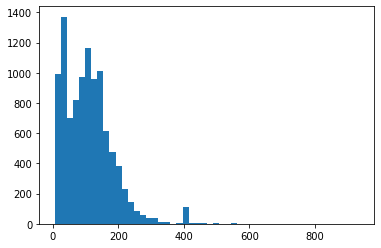

In [14]:
plt.hist([len(tokenizer(text)["input_ids"]) for text in hgnc_id_with_text.values()], bins=50)

### C2) INDRA Pre-training: Filter for entries in which both have a description
Add helper columns for checking the IDs in a straightforward manner

In [9]:
indra_pretraining_ppi["source_id"] = indra_pretraining_ppi['source'].str.extract(r'((?<=HGNC:)\d+)', expand=False)
indra_pretraining_ppi["target_id"] = indra_pretraining_ppi['target'].str.extract(r'((?<=HGNC:)\d+)', expand=False)

<ipython-input-9-7246c158b258>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indra_pretraining_ppi["source_id"] = indra_pretraining_ppi['source'].str.extract(r'((?<=HGNC:)\d+)', expand=False)
<ipython-input-9-7246c158b258>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indra_pretraining_ppi["target_id"] = indra_pretraining_ppi['target'].str.extract(r'((?<=HGNC:)\d+)', expand=False)


In [10]:
indra_pretraining_ppi.head()

,source,relation,target,evidence,pmid,belief_score,source_id,target_id
53485,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),"IL-5 activates Lyn, Syk, and JAK2 tyrosine kin...","other:""sparser:Unknown""",{1.0: True},6016,11491
53486,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),"Therefore, it is unlikely that cyclosporin A p...","other:""reach:Unknown""",{1: True},6016,11491
53487,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),"IL-5 activates Lyn, Syk, and JAK2 and propagat...","other:""sparser:Unknown""",{1.0: True},6016,11491
53488,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),"Among the candidates are Fyn, Btk, Fes, and Sy...","other:""reach:Unknown""",{1: True},6016,11491
53489,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),Previous studies have shown that IL-5 activate...,"other:""reach:Unknown""",{1: True},6016,11491


In [34]:
hgnc_id_with_text.keys()

dict_keys([100, 10000, 10002, 10003, 10006, 10007, 10008, 10009, 1001, 10010, 10011, 10013, 10017, 10018, 10019, 1002, 10020, 10021, 10023, 10026, 10038, 10039, 1004, 10042, 10043, 10044, 10046, 10047, 10048, 10049, 1005, 10050, 10055, 10056, 10057, 10058, 10059, 1006, 10060, 10061, 10062, 10063, 10066, 10067, 10068, 1007, 10071, 10072, 10073, 10075, 10078, 1008, 10082, 10083, 10084, 10085, 10096, 10097, 10098, 10099, 101, 10100, 10101, 10103, 10105, 10107, 10109, 10110, 10111, 10113, 10116, 1012, 10120, 10123, 10128, 10130, 10133, 10137, 10139, 1014, 10140, 10142, 10146, 10147, 10148, 10149, 1015, 10150, 10151, 10153, 10154, 10155, 10157, 10159, 1016, 10160, 10161, 10163, 10164, 10165, 10166, 10168, 1017, 10178, 1018, 10181, 10184, 10186, 10188, 10189, 10193, 10194, 10195, 10196, 10197, 10199, 102, 1020, 10201, 10202, 10204, 10205, 10206, 10207, 10210, 10211, 10212, 10214, 10215, 10216, 10219, 1022, 10220, 10223, 10224, 10225, 10226, 10227, 10229, 1023, 10230, 10231, 10232, 10235, 102

In [11]:
indra_pretraining_ppi_with_description = indra_pretraining_ppi[
    indra_pretraining_ppi["source_id"].isin(hgnc_id_with_text.keys()) & 
    indra_pretraining_ppi["target_id"].isin(hgnc_id_with_text.keys())
]

In [12]:
print(f"Number of entries in the pre-training data after filtering for PPIs with descriptions:",
      f"{len(indra_pretraining_ppi_with_description)}")
print(f"This makes up {len(indra_pretraining_ppi_with_description)/len(indra_pretraining)*100}%", 
      f"of the total pre-training triples")

Number of entries in the pre-training data after filtering for PPIs with descriptions: 949914
This makes up 6.979532834474431% of the total pre-training triples


### C3) INDRA Pre-training: Add the descriptions for source and target

In [13]:
indra_pretraining_ppi_with_description["source_description"] = indra_pretraining_ppi_with_description[
        "source_id"
    ].map(hgnc_id_with_text)
indra_pretraining_ppi_with_description["target_description"] = indra_pretraining_ppi_with_description[
        "target_id"
    ].map(hgnc_id_with_text)
print(len(indra_pretraining_ppi_with_description))
indra_pretraining_ppi_with_description.head()

949914


<ipython-input-13-dc115937da6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indra_pretraining_ppi_with_description["source_description"] = indra_pretraining_ppi_with_description[
<ipython-input-13-dc115937da6a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indra_pretraining_ppi_with_description["target_description"] = indra_pretraining_ppi_with_description[


,source,relation,target,evidence,pmid,belief_score,source_id,target_id,source_description,target_description
53485,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),"IL-5 activates Lyn, Syk, and JAK2 tyrosine kin...","other:""sparser:Unknown""",{1.0: True},6016,11491,This gene encodes a member of a subfamily of R...,This gene encodes a member of a disintegrin an...
53486,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),"Therefore, it is unlikely that cyclosporin A p...","other:""reach:Unknown""",{1: True},6016,11491,This gene encodes a member of a subfamily of R...,This gene encodes a member of a disintegrin an...
53487,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),"IL-5 activates Lyn, Syk, and JAK2 and propagat...","other:""sparser:Unknown""",{1.0: True},6016,11491,This gene encodes a member of a subfamily of R...,This gene encodes a member of a disintegrin an...
53488,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),"Among the candidates are Fyn, Btk, Fes, and Sy...","other:""reach:Unknown""",{1: True},6016,11491,This gene encodes a member of a subfamily of R...,This gene encodes a member of a disintegrin an...
53489,p(HGNC:6016 ! IL5),increases,p(HGNC:11491 ! SYK),Previous studies have shown that IL-5 activate...,"other:""reach:Unknown""",{1: True},6016,11491,This gene encodes a member of a subfamily of R...,This gene encodes a member of a disintegrin an...


### C4) Save the pre-training dataset

In [14]:
indra_pretraining_ppi_with_description.to_csv(os.path.join(PRETRAINING_DIR, 
                                                           "pretraining_triples_ppi.tsv"), 
                                             sep="\t", index=None)

### C5) INDRA Fine-tuning: Filter for entries in which both have a description + Add the descriptions to the datasets

In [19]:
finetuning_datasets_ppi_w_descriptions = []

for dataset, name in zip(finetuning_datasets, task_names):
    dataset_ppi = dataset[dataset["source"].str.startswith('p(HGNC') & dataset["target"].str.startswith('p(HGNC')]
    dataset_ppi["source_id"] = dataset_ppi['source'].str.extract(r'((?<=HGNC:)\d+)', expand=False)
    dataset_ppi["target_id"] = dataset_ppi['target'].str.extract(r'((?<=HGNC:)\d+)', expand=False)
    dataset_ppi_desc = dataset_ppi[
        dataset_ppi["source_id"].isin(hgnc_id_with_text.keys()) & 
        dataset_ppi["target_id"].isin(hgnc_id_with_text.keys())
    ]
    print(f"Number of {name} entries before: {len(dataset)}")
    print(f"Number of {name} entries after PPI filtering: "
          f"{len(dataset_ppi_desc)} ({len(dataset_ppi_desc)/len(dataset) * 100}%)")
    
    dataset_ppi_desc["source_description"] = dataset_ppi_desc[
        "source_id"
    ].map(hgnc_id_with_text)
    dataset_ppi_desc["target_description"] = dataset_ppi_desc[
        "target_id"
    ].map(hgnc_id_with_text)
    
    finetuning_datasets_ppi_w_descriptions.append(dataset_ppi_desc)

<ipython-input-19-3a2a3b870dec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_ppi["source_id"] = dataset_ppi['source'].str.extract(r'((?<=HGNC:)\d+)', expand=False)
<ipython-input-19-3a2a3b870dec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_ppi["target_id"] = dataset_ppi['target'].str.extract(r'((?<=HGNC:)\d+)', expand=False)
<ipython-input-19-3a2a3b870dec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Number of cell_line entries before: 3893
Number of cell_line entries after PPI filtering: 1367 (35.11430773182636%)
Number of cell_type entries before: 4728
Number of cell_type entries after PPI filtering: 1531 (32.38155668358714%)
Number of correct_binary entries before: 12670
Number of correct_binary entries after PPI filtering: 1564 (12.34411996842936%)
Number of correct_multiclass entries before: 12445
Number of correct_multiclass entries after PPI filtering: 1510 (12.13338690237043%)
Number of disease entries before: 4722
Number of disease entries after PPI filtering: 1627 (34.45573909360441%)
Number of location entries before: 5314
Number of location entries after PPI filtering: 1774 (33.38351524275499%)
Number of organ entries before: 4198
Number of organ entries after PPI filtering: 1379 (32.84897570271558%)
Number of species entries before: 29355
Number of species entries after PPI filtering: 7181 (24.462612842786577%)
Number of interaction entries before: 79932
Number of inte

#### C6) Save the fine-tuning datasets

In [20]:
for dataset_ppi, directory, file_name in zip(finetuning_datasets_ppi_w_descriptions, directories, file_names):
    new_file_name = file_name.split(".")[0] + "_ppi.tsv"
    dataset_ppi.to_csv(os.path.join(directory, new_file_name), sep="\t", index=None)